In [1]:
import requests
import json
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
from prepare import basic_clean, tokenize, lemmatize, stem, remove_stopwords, prep_repo_data, split_data
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from acquire import get_df

from wordcloud import WordCloud
from matplotlib import pyplot as plt
import seaborn as sns

import varname

import nltk


import warnings
warnings.filterwarnings("ignore")

### TEST CELLS FOR MODULE CREATION

In [2]:
# function to get repo_names for acquire

def get_repo_names():
    repo_names = []

    for page in range(1,10):
        print(f'Scraping page {page}...')
        link = f'https://github.com/search?p={page}&q=zombie&type=Repositories'
        print(f'Address: {link}')
        response = requests.get(link, headers={'user-agent': 'Codeup DS Hopper'})
        soup = BeautifulSoup(response.text)
        print(f"First repository on page... {soup.find_all('a',class_='v-align-middle')[0]['href']}")
        time.sleep(5)
        for repository in range(0,len(soup.find_all('a',class_='v-align-middle'))):
            repo_names.append(soup.find_all('a', class_='v-align-middle')[repository]['href'])
    time.sleep(10)

    for page in range(11,20):
        print(f'Scraping page {page}...')
        link = f'https://github.com/search?p={page}&q=zombie&type=Repositories'
        print(f'Address: {link}')
        response = requests.get(link, headers={'user-agent': 'Codeup DS Hopper'})
        soup = BeautifulSoup(response.text)
        print(f"First repository on page... {soup.find_all('a',class_='v-align-middle')[0]['href']}")
        time.sleep(5)
        for repository in range(0,len(soup.find_all('a',class_='v-align-middle'))):
            repo_names.append(soup.find_all('a', class_='v-align-middle')[repository]['href'])
    return repo_names

In [3]:
# repo_names = get_repo_names()
# repo_names

In [4]:
# read data.json into dataframe... add to acquire.py
# df = pd.read_json('data.json')
# df.head()

In [5]:
# create columns and add into prepare.py functions

# df['clean'] = [tokenize(basic_clean(readme)) for readme in df.readme_contents]
# df['clean'] = [re.sub('[\n]','', readme) for readme in df.clean]
# df['stemmed'] = [remove_stopwords(stem(readme)) for readme in df.clean]
# df['lemmatized'] = [remove_stopwords(lemmatize(readme)) for readme in df.clean]

In [6]:
# languages = df.language.value_counts()[df.language.value_counts() >= 11].index.to_list()
# df = df[df.language.isin(languages)]

In [7]:
# df.drop_duplicates(inplace=True)

In [8]:
# df.language.value_counts()

In [9]:
# languages = ['HTML','SourcePawn','C','PHP','Ruby']
# repo_names = []

# for page in range(1,10):
#     for language in languages:
#         print(f'Scraping page {page} of {language}...')
#         link = f'https://github.com/search?l={language}&p={page}&q=zombie&type=Repositories'
#         print(f'Address: {link}')
#         response = requests.get(link, headers={'user-agent': 'Codeup DS Hopper'})
#         soup = BeautifulSoup(response.text)
#         print(f"First repository on page... {soup.find_all('a',class_='v-align-middle')[0]['href']}")
#         time.sleep(5)
#         for repository in range(0,len(soup.find_all('a',class_='v-align-middle'))):
#             repo_names.append(soup.find_all('a', class_='v-align-middle')[repository]['href'])
# time.sleep(10)


# for page in range(11,20):
#     for language in languages:
#         print(f'Scraping page {page} of {language}...')
#         link = f'https://github.com/search?l={language}&p={page}&q=zombie&type=Repositories'
#         print(f'Address: {link}')
#         response = requests.get(link, headers={'user-agent': 'Codeup DS Hopper'})
#         soup = BeautifulSoup(response.text)
#         print(f"First repository on page... {soup.find_all('a',class_='v-align-middle')[0]['href']}")
#         time.sleep(5)
#         for repository in range(0,len(soup.find_all('a',class_='v-align-middle'))):
#             repo_names.append(soup.find_all('a', class_='v-align-middle')[repository]['href'])

In [10]:
# repo_names

### Begin Exploration

In [11]:
# retrieve dataframe from acquire and run through prepare.py
df = get_df()
df = prep_repo_data(df)

# split data
train, validate, test = split_data(df)

## IDF
### Using IDF to identify words to exclude from modeling?
- Can high scoring words lead to overfitting?
- Low scoring words can be removed to reduce clutter


In [12]:
repos = [repo for repo in train.lemmatized]

In [13]:
def idf(word):
    '''A simple way to calculate idf for demonstration. Note that this 
    function relies on a globally defined blogs variable.'''
    n_occurences = sum([1 for doc in repos if word in doc])
    return len(repos) / n_occurences

In [14]:
unique_words = pd.Series(' '.join(repos).split()).unique()
unique_words

array(['zombieland', 'documentacaopprojeto', 'final', ...,
       'stylushttptjholowaychukcompost3167096936stylus040releasedhope',
       'enjoy', 'twitterhttptwittercommileskin'], dtype=object)

In [15]:
# put the unique words into a data frame
words_idf = (pd.DataFrame(dict(word=unique_words))
 # calculate the idf for each word
 .assign(idf=lambda train: train.word.apply(idf))
 # sort the data for presentation purposes
 .set_index('word')
 .sort_values(by='idf', ascending=False))

In [16]:
words_idf.describe()

,idf
count,6908.000000
mean,76.722581
std,35.278116
min,1.123596
25%,50.000000
50%,100.000000
75%,100.000000
max,100.000000


In [17]:
words_idf[(words_idf.idf <= 50) & (words_idf.idf >= 10)].idf.value_counts()

50.000000    649
33.333333    344
25.000000    238
20.000000    130
16.666667    116
14.285714    101
12.500000     78
11.111111     66
10.000000     60
Name: idf, dtype: int64

In [18]:
words_idf[words_idf.idf < 10]

,idf
word,
include,9.090909
sem,9.090909
este,9.090909
started,9.090909
open,9.090909
...,...
u,1.149425
n,1.149425
r,1.136364


In [19]:
low_idf_stopwords = words_idf[(words_idf.idf <= 10)].index.to_list()
high_idf_stopwords = words_idf[(words_idf.idf > 50)].index.to_list()
more_stopwords = low_idf_stopwords + high_idf_stopwords

In [20]:
more_stopwords

['character',
 'reload',
 'tag',
 '80',
 'content',
 'purpose',
 'tran',
 'useful',
 'modify',
 'send',
 'detail',
 'enter',
 'close',
 'documentation',
 'enable',
 '17',
 'display',
 'browser',
 'pace',
 'recommend',
 'development',
 'already',
 'found',
 'cd',
 'extra',
 'define',
 'tutorial',
 'site',
 '41',
 'created',
 'ability',
 'working',
 '64',
 'process',
 'limit',
 'nodejs',
 'option',
 'keep',
 'boar',
 'random',
 'status',
 'functional',
 'proper',
 'event',
 'prop',
 'mission',
 'starting',
 'unity',
 'board',
 'around',
 'select',
 'php',
 'fee',
 'live',
 'erb',
 'article',
 'inin',
 'gun',
 'return',
 'environment',
 'include',
 'sem',
 'este',
 'started',
 'open',
 'menu',
 'directory',
 'setting',
 'latest',
 'bash',
 'installation',
 'lose',
 'url',
 'face',
 '51',
 'issue',
 'loaded',
 'gui',
 'string',
 'effect',
 'author',
 'stand',
 'light',
 'bad',
 'style',
 'wise',
 'box',
 'weapon',
 'done',
 'complete',
 'contains',
 'still',
 'place',
 'may',
 'exec',
 'co

Remove more stopwords!

In [21]:
train.columns.to_list()

['repo',
 'language',
 'readme_contents',
 'link',
 'clean',
 'stemmed',
 'lemmatized']

In [22]:
for col in ['readme_contents','link','clean','stemmed','lemmatized']:
    print(col)
    for content in train[col]:
        print(content)

readme_contents
# ZombieLand - Documentação
<p>Projeto final da disciplina de Introdução à Programação, do curso de Engenharia de Computação da UFPB.</p>
<p>Prof.: Lincoln David Nery e Silva.</p>
<p>Alunos:</p>
<a href="https://github.com/hugo451">André Hugo</a> <br>
<a href="https://github.com/Isaac-CI">Isaac Nóbrega</a> <br>
<a href="https://github.com/lucasguedes778">Lucas Guedes</a> <br>
<a href="https://github.com/mayraamaral">Mayra Amaral</a> <br>
<a href="https://github.com/PhellipePalitot">Phellipe Palitot</a> <br>

## Introdução

<p> O jogo foi desenvolvido utilizando a biblioteca <a href="https://www.allegro.cc">Allegro 5</a>, que faz uso da linguagem C. A principal inspiração é o jogo do dinossauro do Google Chrome, que fica disponível no navegador na ausência de internet (<a href="https://tecnoblog.net/259202/origens-jogo-dinossauro-chrome/#targetText=Erro%20de%20conex%C3%A3o%2C%20que%20virou%20jogo%20(e%20procrastina%C3%A7%C3%A3o)&targetText=Tudo%20come%C3%A7ou%20com%20um%

In [23]:
# loop through each column in train
for col in ['clean','stemmed','lemmatized']:
    # apply remove_stopwords function to columns in train
    train[col] = train[col].apply(remove_stopwords, extra_words = more_stopwords)
   
    # repeat for validate and test
    ##### More stopwords was retrieved from the test dataset so no data leakage occurs with this transformation
    validate[col] = validate[col].apply(remove_stopwords, extra_words = more_stopwords)
    test[col] = test[col].apply(remove_stopwords, extra_words = more_stopwords)

In [24]:
# create word strings
javascript_words = basic_clean(' '.join(train[train.language == 'JavaScript'].lemmatized))
c_sharp_words = basic_clean(' '.join(train[train.language == 'C#'].lemmatized))
php_words = basic_clean(' '.join(train[train.language == 'PHP'].lemmatized))
c_words = basic_clean(' '.join(train[train.language == 'C'].lemmatized))
sourcepawn_words = basic_clean(' '.join(train[train.language == 'SourcePawn'].lemmatized))
html_words = basic_clean(' '.join(train[train.language == 'HTML'].lemmatized))
c_plus_plus_words = basic_clean(' '.join(train[train.language == 'C++'].lemmatized))
java_words = basic_clean(' '.join(train[train.language == 'Java'].lemmatized))
python_words = basic_clean(' '.join(train[train.language == 'Python'].lemmatized))
lua_words = basic_clean(' '.join(train[train.language == 'Lua'].lemmatized))
ruby_words = basic_clean(' '.join(train[train.language == 'Ruby'].lemmatized))
all_words = basic_clean(' '.join(train.lemmatized))

In [25]:
# create series of word frequencies per language
javascript_freq = pd.Series(javascript_words.split()).value_counts()
c_sharp_freq = pd.Series(c_sharp_words.split()).value_counts()
php_freq = pd.Series(php_words.split()).value_counts()
c_freq = pd.Series(c_words.split()).value_counts()
sourcepawn_freq = pd.Series(sourcepawn_words.split()).value_counts()
html_freq = pd.Series(html_words.split()).value_counts()
c_plus_plus_freq =pd.Series(c_plus_plus_words.split()).value_counts() 
java_freq = pd.Series(java_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
lua_freq = pd.Series(lua_words.split()).value_counts()
ruby_freq = pd.Series(ruby_words.split()).value_counts()

# all languages word frequency
all_freq = pd.Series(all_words.split()).value_counts()

In [26]:
javascript_freq,
c_sharp_freq,
php_freq,
c_freq,
sourcepawn_freq,
html_freq,
c_plus_plus_freq,
java_freq,
python_freq,
lua_freq,
ruby_freq

software      8
rail          7
rake          6
report        6
cpu           6
             ..
saved         1
finished      1
49            1
particular    1
added         1
Length: 290, dtype: int64

In [27]:
word_counts = pd.concat([javascript_freq, c_sharp_freq, php_freq, c_freq, sourcepawn_freq, html_freq, c_plus_plus_freq, java_freq, python_freq, lua_freq, ruby_freq, all_freq], axis=1).fillna(0).astype(int)
word_counts.columns = ['javascript', 'c_sharp', 'php','c','sourcepawn','html','c_plus_plus','java','python','lua','ruby','all']
word_counts.head()

,javascript,c_sharp,php,c,sourcepawn,html,c_plus_plus,java,python,lua,ruby,all
message,95,5,0,0,4,1,0,0,1,0,0,106
chat,76,3,0,1,3,3,0,0,0,1,0,87
resource,68,3,0,0,0,0,0,0,0,1,0,72
survivor,58,0,0,0,0,0,0,0,0,4,0,62
workshop,57,0,0,0,0,0,0,0,0,1,0,58


In [28]:
# dictionary for word clouds
word_lists = {'javascript':javascript_words,
'c_sharp':c_sharp_words,
'php':php_words,
'c':c_words,
'sourcepawn':sourcepawn_words,
'html':html_words,
'c_plus_plus':c_plus_plus_words,
'java':java_words,
'python':python_words,
'lua':lua_words,
'ruby':ruby_words}

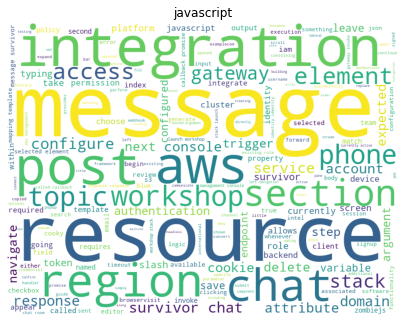

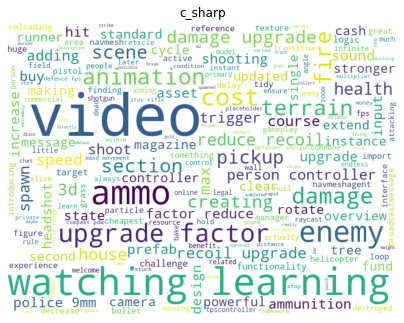

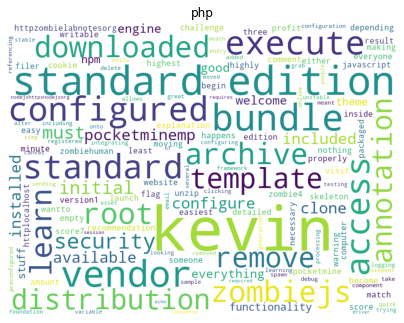

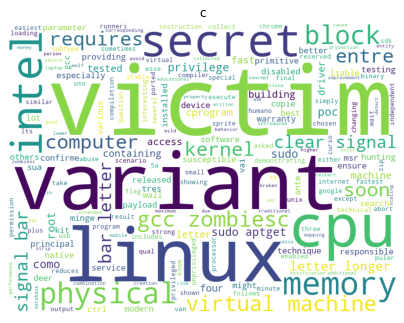

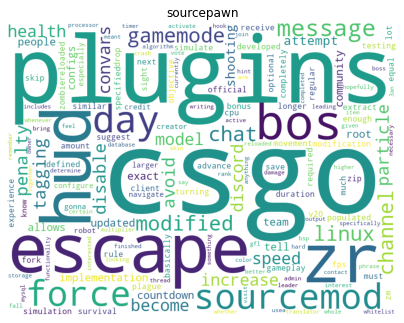

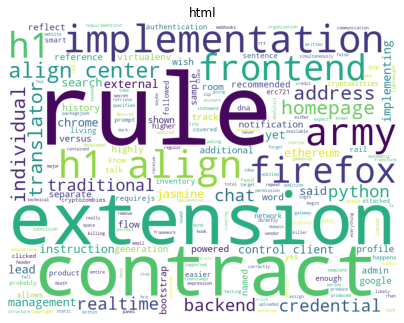

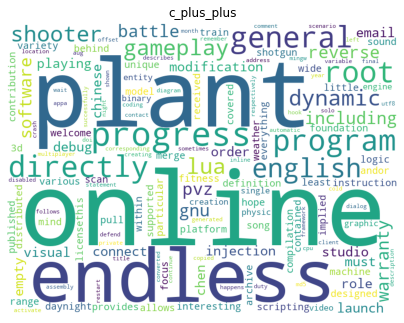

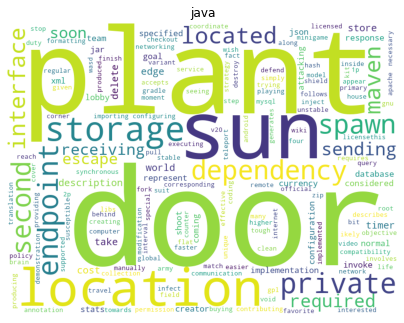

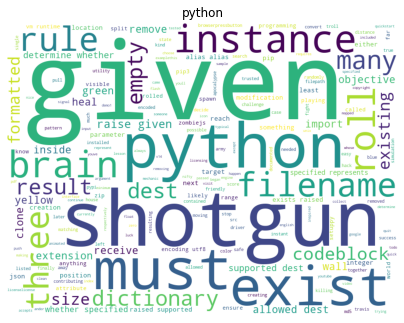

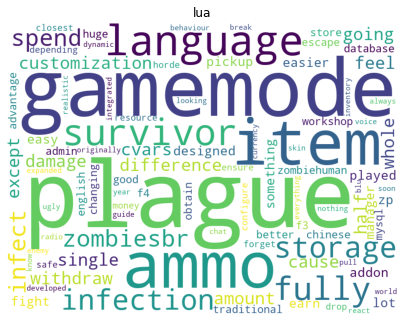

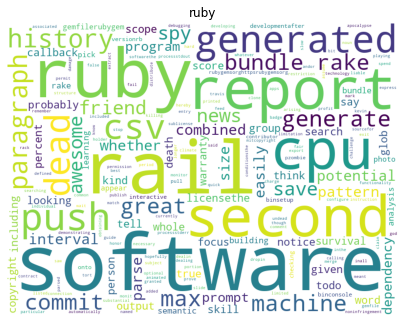

In [29]:
# word clouds
for language in word_lists:
    plt.figure(figsize=(7,7))
    img = WordCloud(background_color='white', width=800, height=600).generate(word_lists[language])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{language}')

### Bigrams

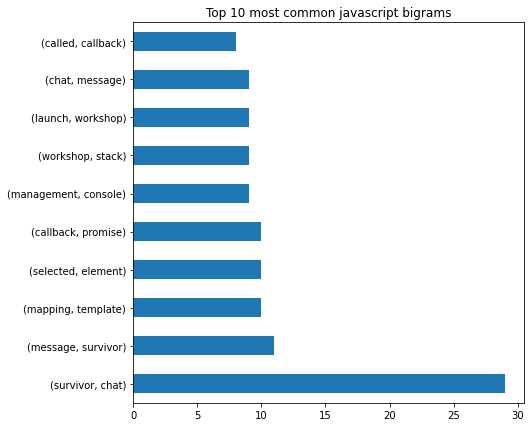

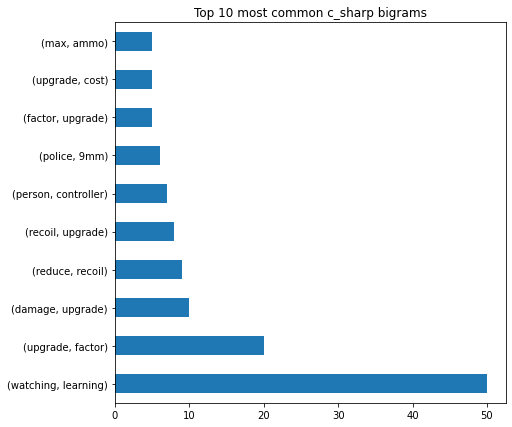

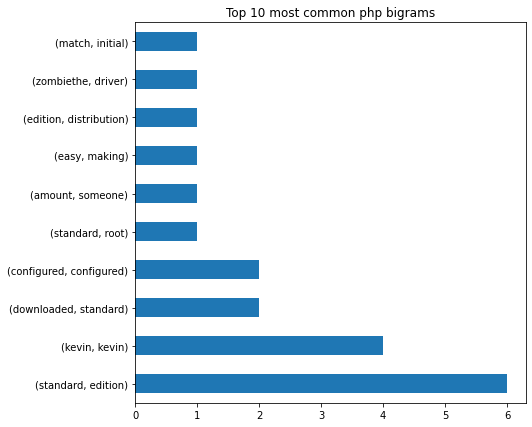

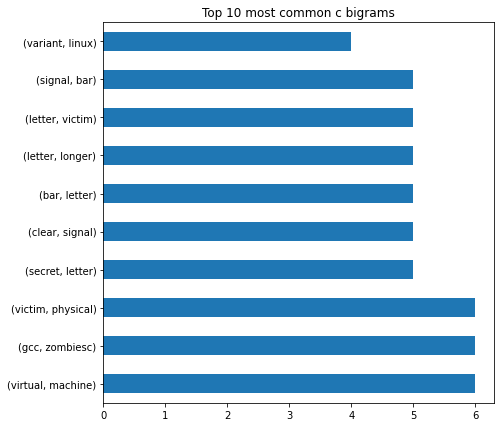

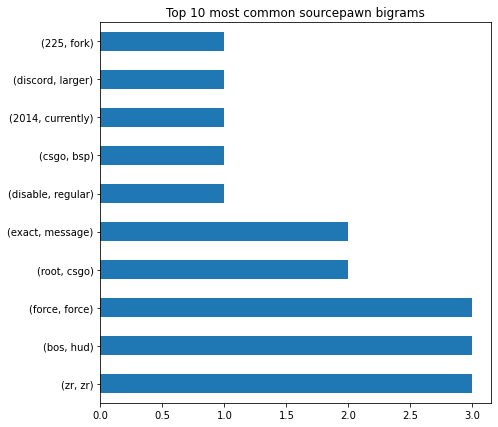

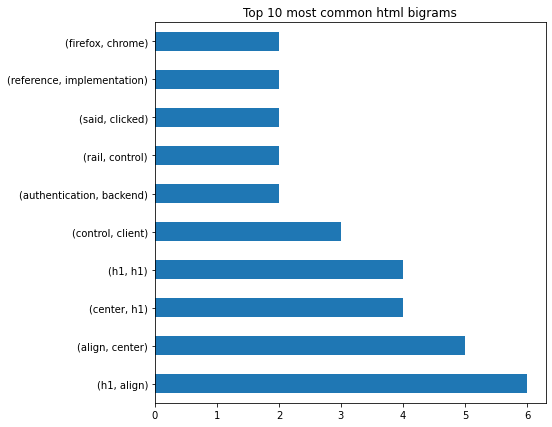

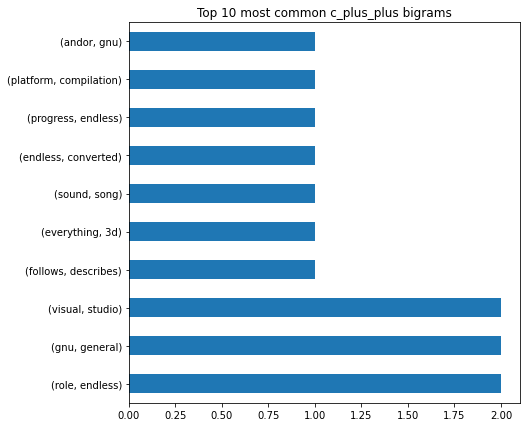

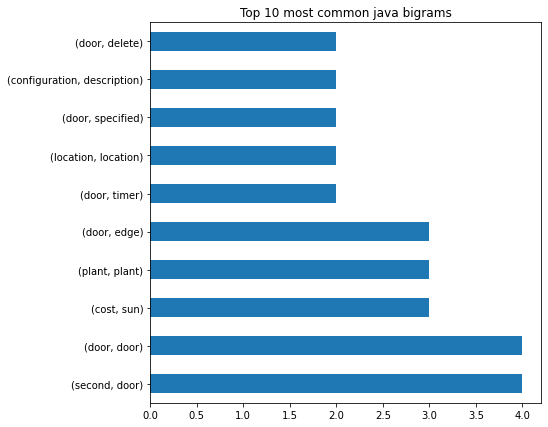

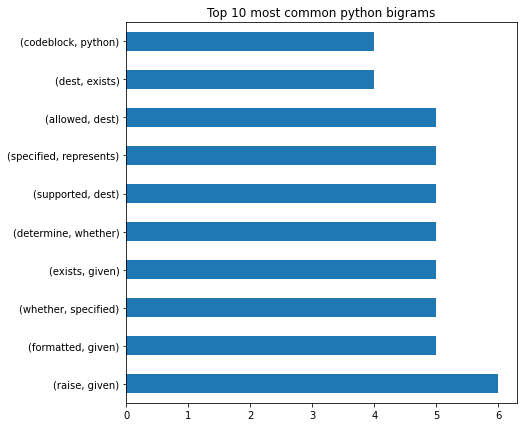

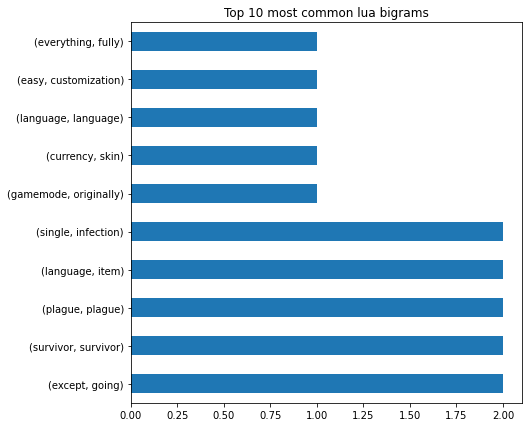

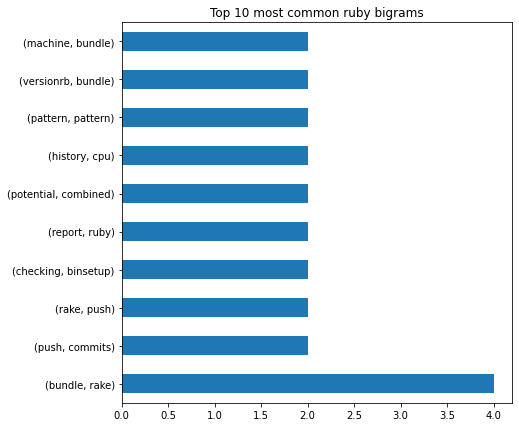

In [30]:
for language in word_lists:
    plt.figure(figsize=(7,7))
    pd.Series(nltk.bigrams(word_lists[language].split())).value_counts().head(10).plot.barh()
    plt.title(f'Top 10 most common {language} bigrams')

### Trigrams

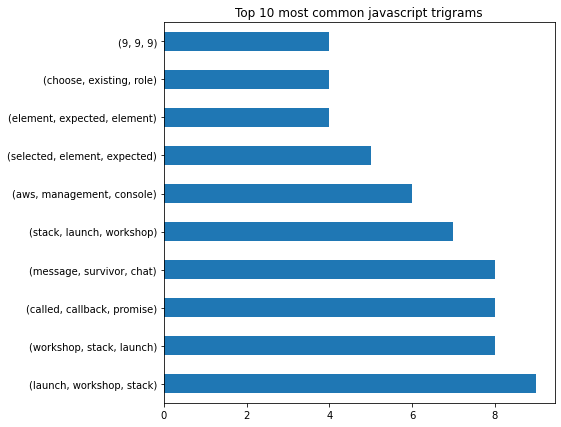

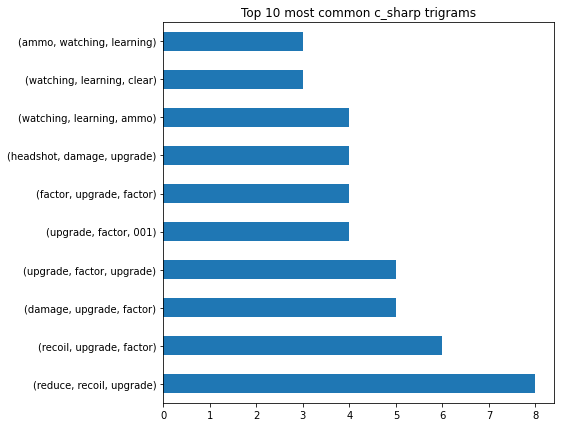

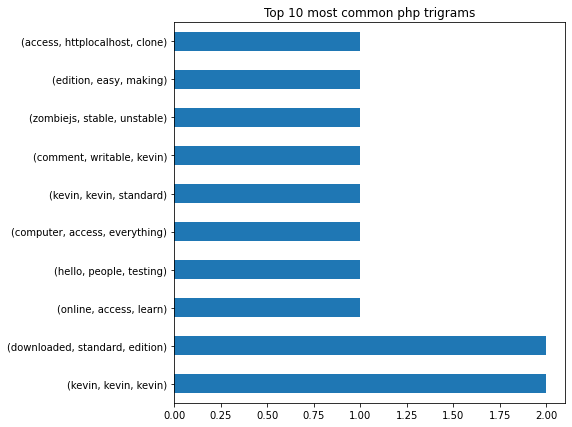

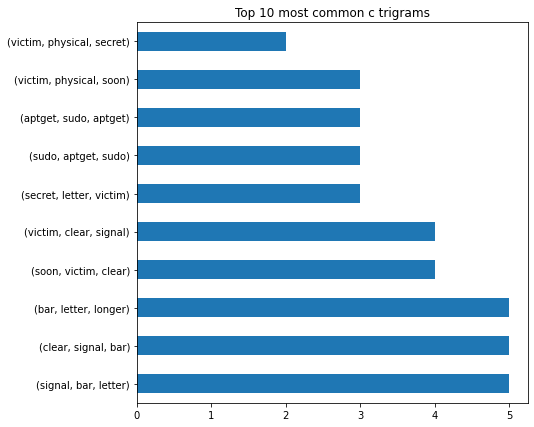

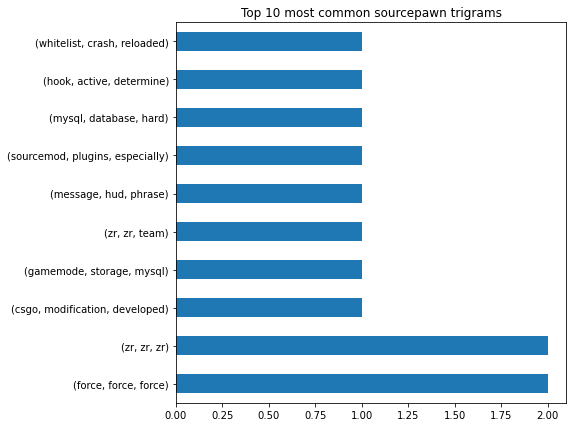

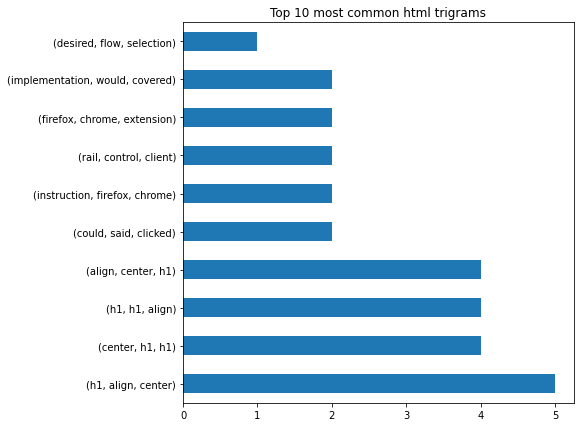

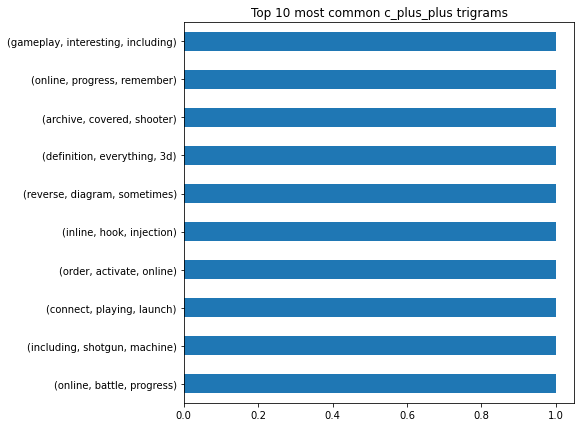

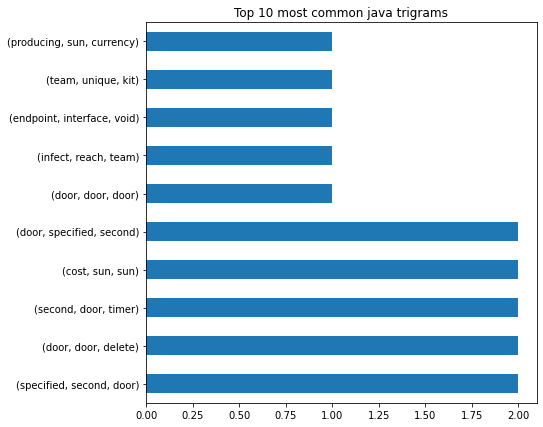

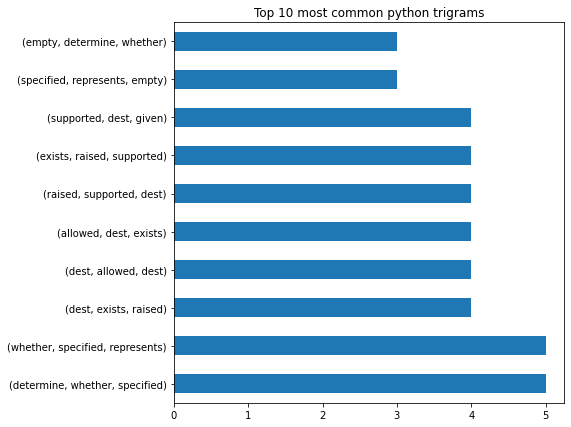

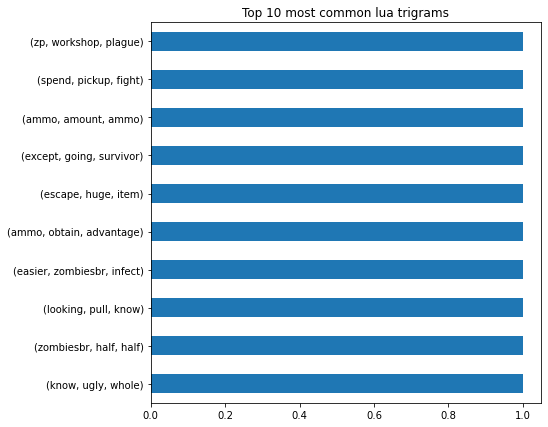

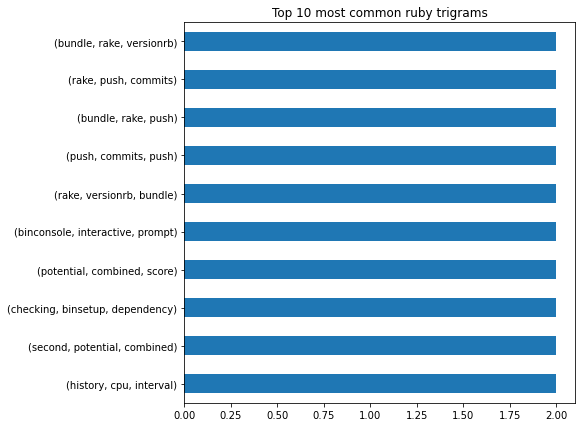

In [31]:
for language in word_lists:
    plt.figure(figsize=(7,7))
    pd.Series(nltk.trigrams(word_lists[language].split())).value_counts().head(10).plot.barh()
    plt.title(f'Top 10 most common {language} trigrams')

### Word Count and Message Length

In [32]:
train['message_length'] = train.lemmatized.apply(len)

train['word_count'] = train.lemmatized.apply(basic_clean).apply(str.split).apply(len)

train.head()

,repo,language,readme_contents,link,clean,stemmed,lemmatized,message_length,word_count
219,hugo451/zombiesland,C,# ZombieLand - Documentação\n<p>Projeto final ...,https://github.com/hugo451/zombiesland,final curso 5a uso principal google chrome int...,final curso neri hrefhttpsgithubcomhugo451andr...,final curso 5a uso principal google chrome int...,359,59
145,kz26/uchicago-hvz,HTML,# University of Chicago Humans versus Zombies\...,https://github.com/kz26/uchicago-hvz,humans versus zombies official humans versus z...,univers versu zombi descriptionthi offici repo...,versus official versus website developed mind ...,998,118
76,dmcinnes/dead-valley,JavaScript,Dead Valley\n===========\n\nEscape from Zombie...,https://github.com/dmcinnes/dead-valley,dead dead html5 grand gamethe hosted indexhtml...,dead valleyescap zombieinfest dead thi html5 g...,dead dead html5 grand gamethe hosted indexhtml...,347,48
111,TheJosh/chaotic-rage,C++,Chaotic Rage\n============\n\n[![Build Status]...,https://github.com/TheJosh/chaotic-rage,scan little shooter allows focus gameplay vari...,statushttpstravisciorgthejoshchaoticragepngbra...,scan little shooter allows focus gameplay vari...,571,72
87,CSCI-E32/zombietranslator,HTML,*The end is nigh!*\nBut we can prepare. In thi...,https://github.com/CSCI-E32/zombietranslator,begin creating translator living either living...,prepar thi assign begin prepar creat simpl zom...,begin creating translator living either living...,585,82


In [33]:
import nltk.sentiment
sia = nltk.sentiment.SentimentIntensityAnalyzer()
sia.polarity_scores(all_words)

{'neg': 0.086, 'neu': 0.771, 'pos': 0.143, 'compound': 0.9999}

In [34]:
train['sentiment'] = train.lemmatized.apply(lambda doc: sia.polarity_scores(doc)['compound'])
train

,repo,language,readme_contents,link,clean,stemmed,lemmatized,message_length,word_count,sentiment
219,hugo451/zombiesland,C,# ZombieLand - Documentação\n<p>Projeto final ...,https://github.com/hugo451/zombiesland,final curso 5a uso principal google chrome int...,final curso neri hrefhttpsgithubcomhugo451andr...,final curso 5a uso principal google chrome int...,359,59,-0.8807
145,kz26/uchicago-hvz,HTML,# University of Chicago Humans versus Zombies\...,https://github.com/kz26/uchicago-hvz,humans versus zombies official humans versus z...,univers versu zombi descriptionthi offici repo...,versus official versus website developed mind ...,998,118,-0.5024
76,dmcinnes/dead-valley,JavaScript,Dead Valley\n===========\n\nEscape from Zombie...,https://github.com/dmcinnes/dead-valley,dead dead html5 grand gamethe hosted indexhtml...,dead valleyescap zombieinfest dead thi html5 g...,dead dead html5 grand gamethe hosted indexhtml...,347,48,-0.5719
111,TheJosh/chaotic-rage,C++,Chaotic Rage\n============\n\n[![Build Status]...,https://github.com/TheJosh/chaotic-rage,scan little shooter allows focus gameplay vari...,statushttpstravisciorgthejoshchaoticragepngbra...,scan little shooter allows focus gameplay vari...,571,72,0.9451
87,CSCI-E32/zombietranslator,HTML,*The end is nigh!*\nBut we can prepare. In thi...,https://github.com/CSCI-E32/zombietranslator,begin creating translator living either living...,prepar thi assign begin prepar creat simpl zom...,begin creating translator living either living...,585,82,0.9657
...,...,...,...,...,...,...,...,...,...,...
22,minkphp/MinkZombieDriver,PHP,Mink Zombie.js Driver\n=====================\n...,https://github.com/minkphp/MinkZombieDriver,zombiejs stable unstable nodejshttpsnodejsorg ...,zombiej stabl unstabl versionhttpsposerpugxorg...,zombiejs stable unstable nodejshttpsnodejsorg ...,124,16,-0.0772
11,dsnezhkov/zombieant,C,# Zombie Ant Farm: A Kit For Playing Hide and ...,https://github.com/dsnezhkov/zombieant,kit playing hide linux tools never enough buil...,zombi kit hide linux edrsvers whybecaus monoli...,kit playing hide linux never enough building s...,471,55,-0.2263
81,CompleteUnityDeveloper2/6_Zombie_Runner,C#,# 06-Zombie-Runner\nIn this section we create ...,https://github.com/CompleteUnityDeveloper2/6_Z...,section person shooter theme cover shooting me...,thi section creat person shooter zombi theme c...,section person shooter theme cover shooting me...,4669,632,-0.9980
117,mileskin/zombie-jasmine-spike,JavaScript,Spike project for trying out [Zombie.js](http:...,https://github.com/mileskin/zombie-jasmine-spike,trying stack couple modules npm npm html5 npm ...,tri jasminehttppivotalgithubcomjasminefin chan...,trying stack couple npm npm html5 npm npm expr...,189,29,0.2263


In [35]:
train.groupby('language').sentiment.agg(['mean','median'])

,mean,median
language,,
C,0.052173,0.00000
C#,-0.034417,0.00000
C++,0.299457,0.00000
HTML,0.142464,0.00000
Java,0.183986,0.00000
JavaScript,0.328600,0.43160
Lua,0.096200,0.00000
PHP,0.115645,0.00000
Python,0.603067,0.84985


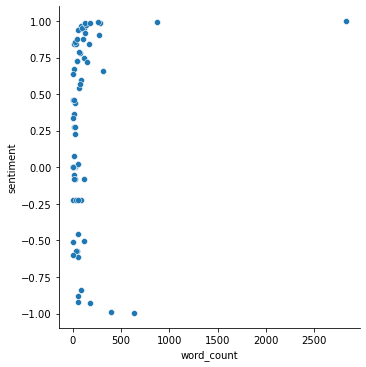

In [36]:
#plot message_length vs sentiment and hue by label
sns.relplot(data = train, x = 'word_count', y = 'sentiment')

## IDF ---- Copied to above
### Using IDF to identify words to exclude from modeling?
- Can high scoring words lead to overfitting?
- Low scoring words can be removed to reduce clutter


In [37]:
# repos = [repo for repo in train.lemmatized]

In [38]:
# def idf(word):
#     '''A simple way to calculate idf for demonstration. Note that this 
#     function relies on a globally defined blogs variable.'''
#     n_occurences = sum([1 for doc in repos if word in doc])
#     return len(repos) / n_occurences

In [39]:
# unique_words = pd.Series(' '.join(repos).split()).unique()
# unique_words

In [40]:
# # put the unique words into a data frame
# words_idf = (pd.DataFrame(dict(word=unique_words))
#  # calculate the idf for each word
#  .assign(idf=lambda train: train.word.apply(idf))
#  # sort the data for presentation purposes
#  .set_index('word')
#  .sort_values(by='idf', ascending=False))

In [41]:
# words_idf.describe()

In [42]:
# words_idf[(words_idf.idf <= 50) & (words_idf.idf >= 10)].idf.value_counts()

In [43]:
# words_idf[(words_idf.idf > 50) | (words_idf.idf <= 10)].index.to_list()

In [44]:
# more_stopwords = words_idf[(words_idf.idf > 50) | (words_idf.idf <= 10)].index.to_list()

Remove more stopwords!

In [45]:
# # loop through each column in train
# for col in train.columns.to_list():
#     # loop through rows in column
#     for content in col:
#         # replace content with additional removed stopwords
#         content = remove_stopwords(content, more_stopwords)

# # repeat for validate and test
# ##### More stopwords was retrieved from the test dataset so no data leakage occurs with this transformation
# for col in validate.columns.to_list():
#     # loop through rows in column
#     for content in col:
#         # replace content with additional removed stopwords
#         content = remove_stopwords(content, more_stopwords)

# for col in test.columns.to_list():
#     # loop through rows in column
#     for content in col:
#         # replace content with additional removed stopwords
#         content = remove_stopwords(content, more_stopwords)


In [46]:
# train

TFIDF

In [49]:
# redefine repos
repos = [repo for repo in train.lemmatized]

# create tfidf object
tfidf = TfidfVectorizer()

# fit/use tfidf
tfidfs = tfidf.fit_transform(repos)
tfidfs

<100x1721 sparse matrix of type '<class 'numpy.float64'>'
	with 4265 stored elements in Compressed Sparse Row format>

In [54]:
tfidf_df = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())

In [56]:
pd.merge(train,tfidf_df,how='left',right_index=True, left_index=True)

,repo,language_x,readme_contents,link,clean_x,stemmed,lemmatized,message_length,word_count,sentiment,...,zombiehuman,zombiejs,zombiereloaded,zombiesbr,zombiesc,zombieszombies,zombiethe,zoom,zp,zr
219,hugo451/zombiesland,C,# ZombieLand - Documentação\n<p>Projeto final ...,https://github.com/hugo451/zombiesland,final curso 5a uso principal google chrome int...,final curso neri hrefhttpsgithubcomhugo451andr...,final curso 5a uso principal google chrome int...,359,59,-0.8807,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
145,kz26/uchicago-hvz,HTML,# University of Chicago Humans versus Zombies\...,https://github.com/kz26/uchicago-hvz,humans versus zombies official humans versus z...,univers versu zombi descriptionthi offici repo...,versus official versus website developed mind ...,998,118,-0.5024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,dmcinnes/dead-valley,JavaScript,Dead Valley\n===========\n\nEscape from Zombie...,https://github.com/dmcinnes/dead-valley,dead dead html5 grand gamethe hosted indexhtml...,dead valleyescap zombieinfest dead thi html5 g...,dead dead html5 grand gamethe hosted indexhtml...,347,48,-0.5719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111,TheJosh/chaotic-rage,C++,Chaotic Rage\n============\n\n[![Build Status]...,https://github.com/TheJosh/chaotic-rage,scan little shooter allows focus gameplay vari...,statushttpstravisciorgthejoshchaoticragepngbra...,scan little shooter allows focus gameplay vari...,571,72,0.9451,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,CSCI-E32/zombietranslator,HTML,*The end is nigh!*\nBut we can prepare. In thi...,https://github.com/CSCI-E32/zombietranslator,begin creating translator living either living...,prepar thi assign begin prepar creat simpl zom...,begin creating translator living either living...,585,82,0.9657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,minkphp/MinkZombieDriver,PHP,Mink Zombie.js Driver\n=====================\n...,https://github.com/minkphp/MinkZombieDriver,zombiejs stable unstable nodejshttpsnodejsorg ...,zombiej stabl unstabl versionhttpsposerpugxorg...,zombiejs stable unstable nodejshttpsnodejsorg ...,124,16,-0.0772,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,dsnezhkov/zombieant,C,# Zombie Ant Farm: A Kit For Playing Hide and ...,https://github.com/dsnezhkov/zombieant,kit playing hide linux tools never enough buil...,zombi kit hide linux edrsvers whybecaus monoli...,kit playing hide linux never enough building s...,471,55,-0.2263,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
81,CompleteUnityDeveloper2/6_Zombie_Runner,C#,# 06-Zombie-Runner\nIn this section we create ...,https://github.com/CompleteUnityDeveloper2/6_Z...,section person shooter theme cover shooting me...,thi section creat person shooter zombi theme c...,section person shooter theme cover shooting me...,4669,632,-0.9980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
117,mileskin/zombie-jasmine-spike,JavaScript,Spike project for trying out [Zombie.js](http:...,https://github.com/mileskin/zombie-jasmine-spike,trying stack couple modules npm npm html5 npm ...,tri jasminehttppivotalgithubcomjasminefin chan...,trying stack couple npm npm html5 npm npm expr...,189,29,0.2263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
